# **Proyecto final**

----------------------

Universidad de Guanajuato, Campus León, División de Ciencias e Ingenierías, Lomas del Bosque 103, Lomas del Campestre, 37150 León, Gto.

## **Análisis de datos**

### **Ana Isabel Moreno Hernández**

---------------------------------

<h1><center>Método de metrópolis utilizando un likelihood de Poisson.</center></h1>

Este proyecto final tiene como objetivo aplicar el método metrópolis para ajustar una distribución de datos a una función utilizando un likelihood de Poisson. 

Este método consiste en calcular el valor del Likelihood, en este caso de Poissson, con nuevos valores para los parámetros y utilizando el modelo supuesto para nuestra distribución de datos. Al calcularse el likelihood con estos parámetros, se compara con el likelihood de un "vecino" y, si el nuevo likelihood es mayor que el anterior, éste se acepta, y si no, se acepta el valor de los parámetros anterior.  

¿Por qué utilizar un likelihood de Poisson? Si se tienen muchos datos, el likelihood más común a utilizar es con distribución Gaussiana. Pero si son pocos datos, es recomendable utilizar un likelihood con distribución de Poisson.

-----------

Intentaremos ajustar una distribución de probabilidades a una distribución de probabilidad lineal, es decir, una distribución con la forma $p(x) = ax + b$, donde $a$ es la pendiente y $b$ es la ordenada al origen.  

Importamos las librerías necesarias. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.special import factorial

Ahora, pensemos en una distribución de frecuencias para ciertos intervalos de energía. 

Tenemos un conjunto de datos de tamaño $N = \sum^M_{j=1}y_j$, con una distribución de probabilidad $p(x) = ax + b$, con $p(x) = 0$ fuera de los límites de $x$. Queremos estimar $a$ y $b$. 

Este conjunto de datos se ve así:

In [16]:
x = np.linspace(0, 20, 21) # Generamos un arreglo de 21 elementos (funcionarán como los puntos intermedios de las barras de un histograma) 
y = 3*x + 2 # Función lineal con pendiente 3 y ordenada 2

error = np.random.randint(0, 2, size = 21) # Generamos errores aleatorios

for i in range(len(error)):
    y[i] = y[i] + error[i] # Modificamos la función para que no sea "perfecta" la distribución de datos

Convertimos lo anterior a tipo array. 

In [17]:
y = np.array(y)
x = np.array(x)

Graficamos nuestra distribución:

Text(0, 0.5, 'p(x)')

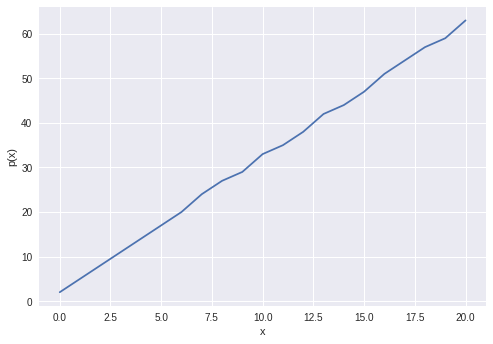

In [18]:
plt.style.use('seaborn')

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('p(x)')

Cuando no se tienen muchos datos. el likelihood para cada $y_i$ debe ser modelada utilizando la distribución de Poisson: 

$p(k|\mu_i) = \mu_i^kexp(-\mu_i)/k!$, donde $k = y_i$ y $\mu_i = a*x_i + b$.

Con priors uniformes para $a$ y $b$,

$\ln L = \sum^M_{i=1}[y_i\ln(a*x_i+b*)-a*x_i-b* - \ln(y_i!)]$

----------------------

## **Metrópolis utilizando $\ln L$**

Definimos ahora nuestro modelo y nuestro logaritmo natural del likelihood:

In [19]:
def modelo(theta, x):
    return theta[0]*x + theta[1] # Lineal

def log_likelihood(theta, data): # Función que calcula el likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    model = modelo(theta,equis) # Calculamos el modelo utilizando la función modelo
    log_likelihood = ye*np.log(model)-model-np.log(factorial(ye))  # Obtenemos L
    return log_likelihood.sum() # Regresamos la suma de todos los L

Intentamos primero con un camino, sólo para verificar que nuestro método de metrópolis funciona. 

In [20]:
rango = 5000

a0 = 2.5
b0 = 1
lnlike0 = log_likelihood([a0, b0], [x,y])

a_sample = [a0]
b_sample = [b0]

sigma = 0.01

for j in range(1,rango):
    a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
    b_new = np.random.normal(b_sample[len(a_sample)-1], sigma)
    like = log_likelihood([a_new, b_new], [x,y])
    if like>lnlike0:
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)
    elif lnlike0-like<-math.log(random.uniform(0,1)):
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)

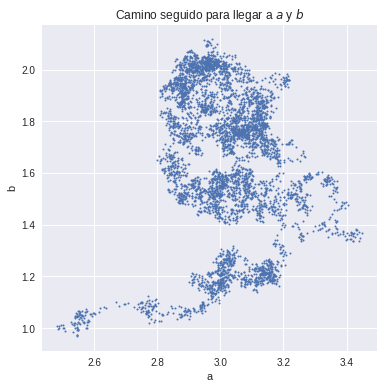

In [21]:
plt.figure(figsize = (6,6))
plt.plot(a_sample,b_sample, 'o', markersize = 2)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $a$ y $b$')
plt.grid('True')

Observamos que el modelo no converge a algún valor, así que ahora usamos la siguiente opción.

-------------------------------------

## **Metrópolis utilizando $ L = \displaystyle\prod_i\mu_i^kexp(-\mu_i)/k!$, donde $k = y_i$ y $\mu_i = a*x_i + b$.**

In [22]:
def modelo(theta, x):
    return theta[0]*x + theta[1]

def likelihood(theta, data): # Función que calcula el likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    model = modelo(theta,equis) # Calculamos el modelo utilizando la función modelo
    likelihood = (model**y)*np.exp(-1*(model))/factorial(ye)  # Obtenemos L
    return likelihood.prod() # Regresamos la suma de todos los L

### **Un camino**

In [23]:
rango = 40000 # pasos

a0 = 7 # Valores iniciales para los parámetros
b0 = 1
lnlike0 = likelihood([a0, b0], [x,y]) # Valor inicial para el likelihood

a_sample = [a0] 
b_sample = [b0]

sigma = 0.01

for j in range(1,rango):
    a_new = np.random.normal(a_sample[len(a_sample)-1], sigma) # Busca vecinos alrededor de a
    b_new = np.random.normal(b_sample[len(a_sample)-1], sigma) # Busca vecinos alrededor de b
    like = likelihood([a_new, b_new], [x,y])
    if like>lnlike0: # Compara qué likelihood es el mayor.
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)
    elif (lnlike0/like)>(1/random.uniform(0,1)): # Segundo condicional para aceptar el nuevo valor de los parámetros
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)

Graficamos para observar si este camino ha convergido a algún valor para $a$ y $b$.

(1.75, 2.25)

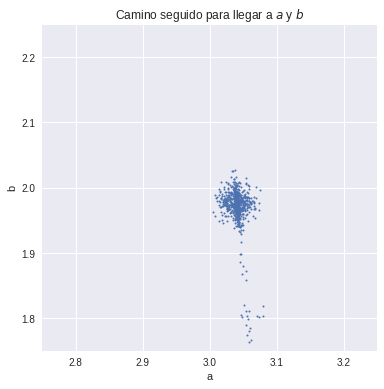

In [24]:
plt.figure(figsize = (6,6))
plt.plot(a_sample,b_sample, 'o', markersize = 2)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $a$ y $b$')
plt.grid('True')
plt.xlim(2.75, 3.25)
plt.ylim(1.75, 2.25)

Observamos los histogramas para cada parámetro.

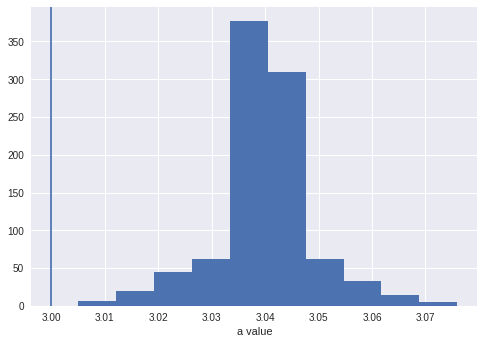

In [25]:
plt.hist(a_sample[2000::])
plt.xlabel('a value')
plt.axvline(3);

Observamos que este histograma tiene una forma parecida a una distribución de Poisson, además de que es muy cercano al valor real de la función. 

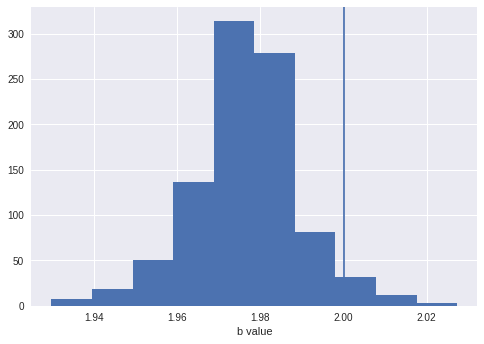

In [26]:
plt.hist(b_sample[2000::])
plt.xlabel('b value')
plt.axvline(2);

Notamos que $b$ también tiene una distribución parecida a una distribución de Poisson, además de que es muy cercano al valor de la función real. 

### **Múltiples caminos**

Ahora implementamos nuestro método utilizando múltiples caminos. 

In [27]:
np.random.seed(42)

El modelo y el likelihood siguen siendo los mismos.

In [28]:
def modelo(theta, x):
    return theta[0]*x + theta[1]

def likelihood(theta, data): # Función que calcula el likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    model = modelo(theta,equis) # Calculamos el modelo utilizando la función modelo
    likelihood = (model**y)*np.exp(-1*(model))/factorial(ye)  # Obtenemos L
    return likelihood.prod() # Regresamos la suma de todos los L

Agregamos un prior a los valores $a$ y $b$.

In [29]:
a_total = [] # Aquí se guardan los valores de todos los caminos 
b_total = []

rango = 40000 # Establecemos 40000 pasos para cada camino

for k in range(20):   # Hacemos 20 caminos
    a0 = np.random.uniform(2, 4, 20) # Los valores iniciales para cada camino serán entre 2 y 4
    b0 = np.random.uniform(1, 3, 20) # Los valores iniciales para cada camino serán entre 1 y 3
    a_sample = [a0[k]]
    b_sample = [b0[k]]
    lnlike0 = likelihood([a0[k], b0[k]], [x,y]) # Calculamos el likelihood 0 para el camino k
    for j in range(1,rango):
        a_new = np.random.normal(a_sample[len(a_sample)-1], sigma) # Encontramos vecinos alrededor del valor anterior de a
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
        if a_new <= 4 and a_new >= 2.5 and b_new <= 3 and b_new >= 1: # Prior
            like = likelihood([a_new, b_new], [x,y]) # Calculamos el nuevo likelihood
            if like>lnlike0: # Aceptamos el que tiene el valor mayor
                lnlike0 = like
                a_sample.append(a_new)
                b_sample.append(b_new)
            elif (lnlike0/like)>(1/random.uniform(0,1)): # Segunda condición para aceptar el valor de a y b
                lnlike0 = like
                a_sample.append(a_new)
                b_sample.append(b_new)
    a_total.append(a_sample) # Guardamos
    b_total.append(b_sample)

Graficamos el camino seguido para llegar a los valores de $a$ y $b$ para cada camino. 

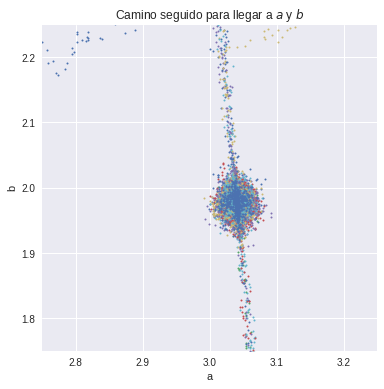

In [30]:
plt.figure(figsize = (6,6))
for k in range(20):
    plt.plot(a_total[k],b_total[k], 'o', markersize = 2)
    

plt.xlabel('a')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $a$ y $b$')
plt.grid('True')
plt.xlim(2.75, 3.25)
plt.ylim(1.75, 2.25);

Quitamos el burning.

In [31]:
a_new = []
b_new = []

burn = 400
for i in range(len(a_total)):
    if(len(a_total[i])>burn and len(b_total[i])>burn):
        a_new.append(a_total[i][burn:])
        b_new.append(b_total[i][burn:])

(2.9, 3.1)

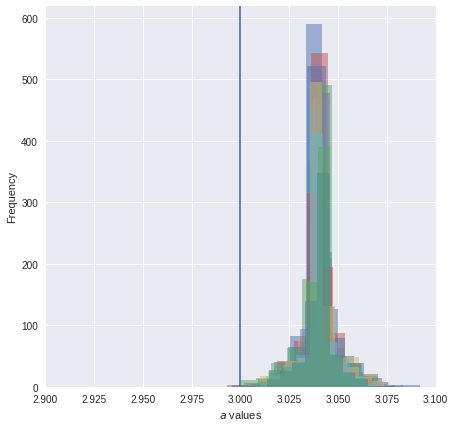

In [32]:
plt.figure(figsize = (7,7))
for i in range(len(a_new)):
    plt.hist(a_new[i],alpha = 0.5)

plt.axvline(3)
plt.xlabel('$a$ values')
plt.ylabel('Frequency');
plt.xlim(2.9,3.1)

(1.9, 2.1)

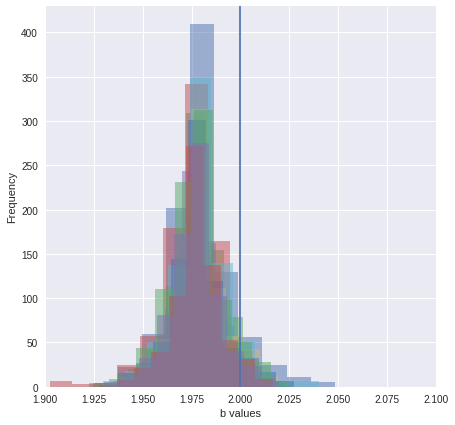

In [33]:
plt.figure(figsize = (7,7))
for i in range(10):
    plt.hist(b_new[i],alpha = 0.5)

plt.axvline(2)
plt.xlabel('b values')
plt.ylabel('Frequency');
plt.xlim(1.9, 2.1)

Nuevamente en estos dos histogramas se observa una distribución de tipo Poisson. 

**¿Cómo sabemos si en realidad nuestros caminos han convergido a algún valor?**

Usamos el método de Gelman-Rubin para determinar si las cadenas han convergido. Referencia: https://arxiv.org/pdf/1812.09384.pdf

In [34]:
n = len(a_new)

def prom_x_i(x_it):
    return np.mean(x_it) # Promedio de un camino

def prom_mu(x_i):
    sum = 0
    for i in range(n):
        sum = sum + prom_x_i(x_i[i]) # Promedio de todos los caminos
    return sum/n

def s_i2(x_it):
    return np.std(x_it) # Desviación estándar de un camino

def s2(x_i):
    sum = 0
    for i in range(n):
        sum = sum + s_i2(x_i[i]) # Desviación estándar de todos los caminos
    return sum/n

def B_n(x_i): # Parámetro Bn
    sum = 0
    for i in range(n):
        sum = sum + (prom_x_i(x_i[i])-prom_mu(x_i))**2
    return sum/(n-1)

def sigma_gorro2(x_i, m):  
    return (m-1)*s2(x_i)/m + B_n(x_i)

def R(x_i, m): # Parámetro R
    return math.sqrt(sigma_gorro2(x_i, m)/s2(x_i))

In [35]:
R(a_new, len(a_new[0]))

0.999470569513566

In [36]:
R(b_new, len(b_new[0]))

0.9995265459103092

Como lo visto en la referencia, mientras más cercano sea R a 1 para cada parámetro, significa que nuestros caminos han convergido a un valor para el para cada parámetro.

**Cálculo de medianas**

Para conocer el valor definitivo de los parámetros $a$ y $b$ es necesario calcular las medianas de los arreglos que guardan los valores para cada parámetro. Esto se logra con lo siguiente:

In [37]:
from statistics import median

In [38]:
medianaa = []

for i in range(len(a_new)):
    medianaa.append(np.median(a_new[i])) # Calculamos mediana de cada camino

In [39]:
medianab = []

for i in range(len(b_new)):
    medianab.append(np.median(b_new[i])) # Calculamos mediana de cada camino

Guardamos e imprimimos:

In [40]:
aa = median(medianaa)
be = median(medianab)
print(aa, be)

3.0402739425526004 1.9777675996319268


**Convergencia de caminos**

Ahora graficamos el valor de $a$ y $b$ en cada iteración. 

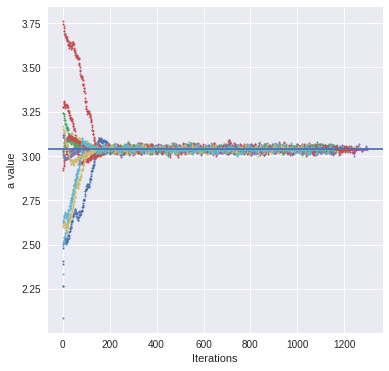

In [41]:
plt.figure(figsize = (6,6))

for i in range(1,len(a_total)):
    iteraciones = np.linspace(1, len(a_total[i]), len(a_total[i]))
    plt.plot(iteraciones, a_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(aa)
plt.ylabel('a value');

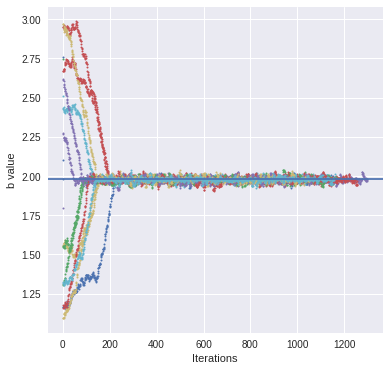

In [42]:
plt.figure(figsize = (6,6))

for i in range(1,len(b_total)):
    iteraciones = np.linspace(1, len(b_total[i]), len(b_total[i]))
    plt.plot(iteraciones, b_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(be)
plt.ylabel('b value');

Y sí, todos los caminos llegan a converger a casi el mismo valor. 

**Ajuste**

¿Cómo se verá nuestro ajuste gráficamente?

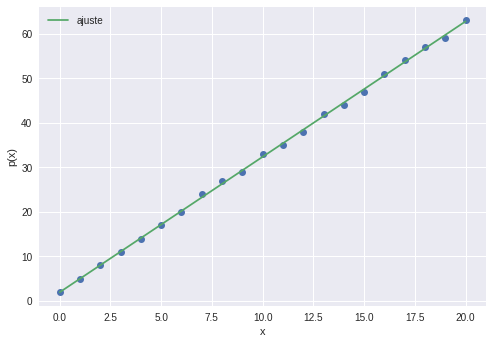

In [43]:
plt.plot(x, y, 'o')
plt.plot(x, aa*x + be, label = 'ajuste')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend();

---------------------------------------

<h1><center>EMCEE con Poisson</center></h1>

Para utilizar EMCEE primero definimos nuestro likelihood. 

Aunque en la sección anterior se utilizó el likelihood de la forma  $ L = \displaystyle\prod_i\mu_i^kexp(-\mu_i)/k!$, donde $k = y_i$ y $\mu_i = a*x_i + b$, en este caso utilizamos el logaritmo natural del likelihood que está dado por: $ \ln L = \sum^M_{i=1}[y_i\ln(a*x_i+b*)-a*x_i-b* - \ln(y_i!)]$, esto fuerza al likelihood a ser siempre positivo. De esta forma, 

In [44]:
def modelo(theta, x):
    return theta[0]*x + theta[1]

def likelihood(theta, data): # Función que calcula el likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    model = modelo(theta,equis) # Calculamos el modelo utilizando la función modelo
    likelihood = ye*np.log(model)-model-np.log(factorial(ye))  # Obtenemos L
    return -likelihood.sum() # Regresamos la suma de todos los L

Una buena forma de encontrar el valor óptimo de este likelihood es utilizando el módulo de scipy.optimize.

In [45]:
import scipy.optimize as op

Vemos si nuestra función de likelihood funciona:

In [46]:
likelihood([3.5,1.8],[x,y])

59.029104684125834

Elegimos un punto inicial y utilizamos el módulo de scipy.optimize:

In [47]:
ini_point = (2.5,3.5) # Punto inicial para los parámetros a y b

data = np.array([x,y]) # Convertimos a array nuestra distribución de datos
# Utilizamos scipy.optimize
min_sol = op.minimize(likelihood, ini_point, args = data, method = 'L-BFGS-B', bounds=((-10,10),(-10,10)))

Imprimimos la solución:

In [48]:
min_sol

      fun: 53.14159119781863
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52651283e-06,  2.84217094e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 11
   status: 0
  success: True
        x: array([3.04032791, 1.97767134])

Y obtenemos valores para $a$ y $b$ muy cercanos a nuestra función. 

Ahora, para utilizar EMCEE necesitamos definir un prior:

In [49]:
import emcee
import tqdm

In [50]:
def log_prior(theta):
    a, b = theta
    if 0.05 < a < 4 and 0 < b < 3:
        return 0.0
    return -np.inf

Y nuestro likelihood con prior es:

In [51]:
def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - likelihood(theta, [x, y])

Corremos EMCEE con 7 caminadores y 50000 pasos cada uno. Es importante mencionar que no fue necesario correr el programa con el servidor debido a que las operaciones son entre 'arrays', por lo que EMCEE no se toma mucho tiempo para correr. 

In [52]:
pos = min_sol.x + 1e-4 * np.random.randn(7, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 50000, progress=True);

/home/anita/.conda/envs/data_main/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 50000/50000 [04:19<00:00, 192.58it/s]


Hacemos las gráficas de valor para $a$ y $b$ contra iteración. 

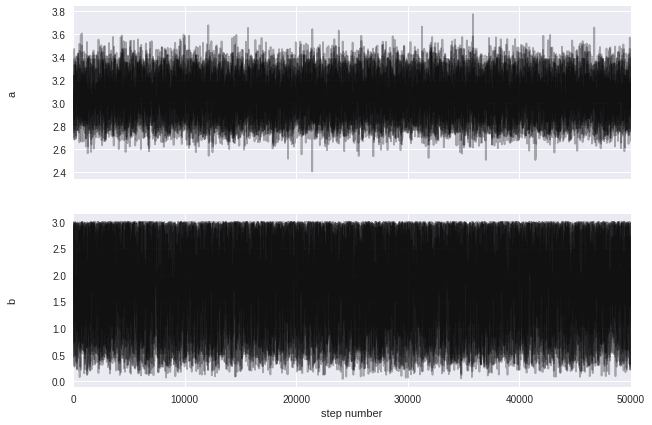

In [53]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [54]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(23282, 2)


Finalmente, utilizamos corner para observar la distribución de cada parámetro y en conjunto. 

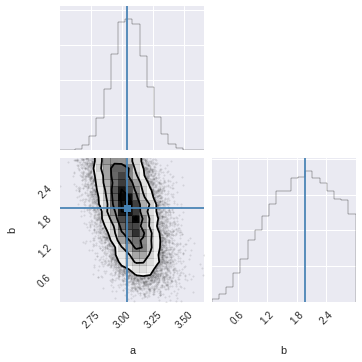

In [55]:
import corner
plt.style.use('seaborn')
fig = corner.corner(
    flat_samples, labels=labels, truths=min_sol.x
);
plt.show;

Como puede observarse en esta última figura, las distribuciones para $a$ y $b$ son muy parecidas a una distribución de Poisson.

Calculamos percentiles 16, 50 y 84 para cada parámetro. Imprimimos:

In [56]:
from IPython.display import display, Math
median = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    median.append(mcmc[1])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Graficamos estos valores con nuestros datos para observar el ajuste:

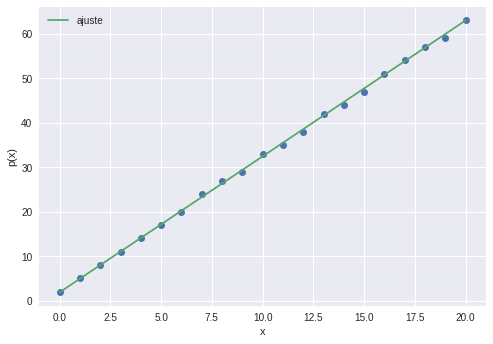

In [57]:
plt.plot(x, y, 'o')
plt.plot(x, median[0]*x + median[1], label = 'ajuste')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend();

-------------------------------

<h1><center>Multinest con Poisson</center></h1>

Para el caso de Multinest, fue necesario utilizar el servidor. Para observar los resultados y el script de multinest, estos se encuentran en el siguiente link: https://github.com/DCIDA2019/da2019-anaisabelotodo/tree/master/Proyecto_final/Multinest o en esta misma carpeta con el nombre de Multinest. De la misma forma, se encontraron los parámetros que mejor ajustan el modelo lineal presentado al inicio de este notebook. 

----------------------------------------------------

<h1><center>Funciones para la energía E</center></h1>

Para este proyecto, se tenía planeado ajustar una distribución de energías utilizando un likelihood de Poisson. 

El modelo para este proyecto era
$\lambda = M(E,\Theta) + S(E,\eta) + B(E)$

$S$ está modelada por:
    $d\Phi/dE = N_s(E/E_p)^{-\alpha_s}$, donde $N_s$ y $\alpha_s$ son parámetros (normalización e índice espectral, respectivamente), mientras que $E_p = 4726.70MeV$ y es una energía de referencia.
    
$M$ está modelada por:
    $d\Phi/dE = N_0(E/MeV)^{-\Gamma}e^{-E/E_{cut}}$, donde $N_0$ es la normalización, $\Gamma$ es el índice espectral y $E_{cut}$ es la energía de corte. Serán tres parámetros nuevos para ajustar con nuestro  likelihood. 

**Para S:**

In [58]:
def ese(N_s, a_s, E):
    E_p = 4726.70 # MeV
    return N_s*(E/E_p)**(-a_s)

Text(0, 0.5, '$d\\Phi/dE$')

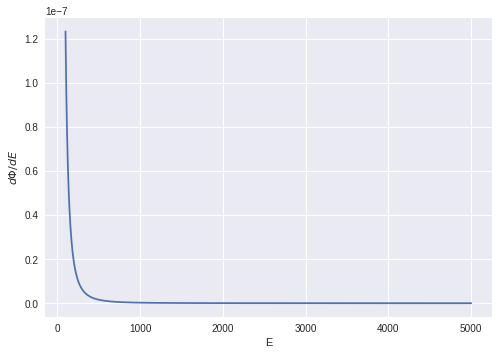

In [59]:
a_s = 2.70
N_s = 10**(-11.43)

E = np.linspace(100, 5000,2000) #MeV
S = ese(N_s,a_s,E)

plt.plot(E,S)
plt.xlabel('E')
plt.ylabel('$d\Phi/dE$')

**Para M**

In [60]:
def phi(N_0, gamma, E_cut, E):
    return N_0*(E)**(-gamma)*np.exp(-E/E_cut)

In [61]:
E_cut = 10**3.55
N_0 = 10**-6.89
gamma = 1.58

dphi_dE = phi(N_0, gamma, E_cut, E)

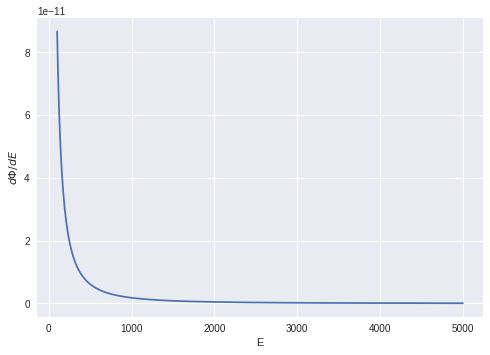

In [63]:
plt.plot(E, dphi_dE)
plt.xlabel('E')
plt.ylabel('$d\Phi/dE$');

**Número de eventos esperados**

El número de eventos esperados para la i-ésimo bin de energía está dada por:
$M(E_i) = \int^{E_{i+1}}_{E_i}\int_{\Delta\Omega}d\Omega\epsilon (E) PSF(E,\Theta)d\Phi/dE$

Hacemos PSF y $\epsilon$ arreglos de 1's.

In [71]:
PSF = np.ones(len(E))
epsilon = np.ones(len(E))

Sabemos que $\Theta\epsilon[0,0.2^\circ]$

Y para integrar utilizamos Quad. Dado que es una doble integral, utilizaremos double quad:

In [73]:
from scipy import integrate

Lo primero que hacemos es establecer los límites de la primera integral, los cuales son $[E_i,E_{i+1}]$ y denotamos como $a = E_i$ y $b = E_{i+1}$. Luego, los límites para $\theta$ son $[0^\circ, 2^\circ]$, los cuales convertimos a radianes. 

La función a integrar se define en la parte de funcion =  lambda theta, E: "definicion", la cual, debido a que tenemos $i$ energías, debe ser iterativa y tener un valor exacto para cada i-ésima energía. 

Finalmente, para integrar, utilizamos dblquad que toma como argumentos la función, los límites de theta y al final los límites de la Energía. Guardamos en un arreglo $M$ los resultados de todas las integrales y al final graficamos. 

In [133]:
M = []
for i in range(len(E)-1):
    a = E[i]
    b = E[i+1]
    funcion = lambda theta, E: epsilon[i]*PSF[i]*N_0*a**(-gamma)*math.exp(-a/E_cut) # Función
    M.append(integrate.dblquad(funcion, 0, 0.2*math.pi/180, lambda E: a, lambda E: b)[0]) # Tomamos sólo el valor de la integral

Integrate.dblquad te da como resultado el valor de la integral y un error asociado a éste. 

In [134]:
M[0:5]

[7.413965617021976e-13,
 7.130720692992872e-13,
 6.864504564809647e-13,
 6.613932105817452e-13,
 6.377759016862523e-13]

Éstos son los valores de la integral en cada iteración.

Graficamos:

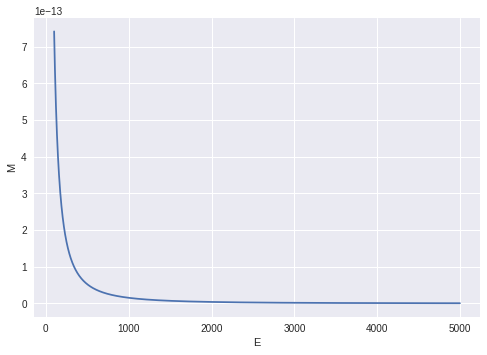

In [137]:
plt.plot(E[0:len(E)-1], M)
plt.xlabel('E')
plt.ylabel('M');

Y así se observa el número de eventos esperados para el i-ésimo bin de energía utilizando PSF y $\epsilon$ como arreglos de 1's. 

----------------------------

<h1><center>Referencias</center></h1>

- *Statistics, Data Mining and Machine Learning in Astronomy.* A practical python guide for the Analisis of surve Data. Princeton series in modern observational astronomy.  

- *EMCE*. url: https://emcee.readthedocs.io/en/stable/user/install/ 

- Multinest. url: https://github.com/JohannesBuchner/PyMultiNest 

- *On the origin of the gamma-ray emission from Omega Centauri: Milisecond pulsars and dark matter annihilation*. Javier Reynoso-Cordova, Oleg Burgueño, Alex Geringer-Sameth, Alma X. González-Morales, Stefano Profumo and O. Valenzuela. arXiv:1907.06682v1

- Scipy.integrate. ulr: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html